In [1]:
import os
import glob
import requests
import geopandas as gpd
from requests.auth import HTTPBasicAuth
from shapely.geometry import shape
import numpy as np
import subprocess
import json
import pathlib
import pandas as pd
headers = {'Content-Type': 'application/json'}

############# SET THESE VARIABLES ######################
# redefined based on the filter you want to use

from geojson_COPP_BS import domain 


domainID = 'COPP' # name of the domain, used for file naming
name = 'COPP'

# enter the Planet user API key
apiKey = 'PLAK198d7255136b4c28b3cac7446a904121'
#apiKey = 'PLAKc327f43c84e84111a5101e3674f3d115' # steven's key
item_type = "PSScene"
asset__type = "ortho_analytic_4b_sr"
# asset_type = "ortho_analytic_8b_sr"
bundle_type = "analytic_sr_udm2"
# bundle_type = "analytic_8b_sr_udm2"

# data download location
# out_direc = f'/home/etboud/projects/data/planet/{name}/'
# out_direc= '/home/etboud/projects/data/planet/ndvi_8B/'
out_direc = '/data0/images/planet/emma/planet/COPP/'

#out_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/'
############# DON'T CHANGE VARIABLES BEYOND THIS ############

In [4]:
############ FUNCTIONS. DON'T CHANGE THESE!!! #########
def build_payload(item_ids, item_type, bundle_type, aoi_coordinates):
    payload = {
        "name": item_ids[0],
        "source_type": "scenes",
        "products": [
            {
                "item_ids": item_ids,
                "item_type": item_type,
                "product_bundle": bundle_type
            }
        ],
        "tools": [
            {
                "clip": {
                    "aoi": {
                        "type": "Polygon",
                        "coordinates": aoi_coordinates
                    }
                }
            }
        ]
    }
    return payload

def order_now(payload,apiKey):
    orders_url = 'https://api.planet.com/compute/ops/orders/v2'
    response = requests.post(orders_url, data=json.dumps(payload), auth=HTTPBasicAuth(apiKey, ''), headers=headers)
    print(response)

    if response.status_code==202:
        order_id =response.json()['id']
        url = f"https://api.planet.com/compute/ops/orders/v2/{order_id}"
        # feature_check = requests.get(url, auth=(PLANET_API_KEY, ""))
        feature_check = requests.get(url, auth=HTTPBasicAuth(apiKey, ''))
        if feature_check.status_code==200:
            print(f"Submitted a total of {len(feature_check.json()['products'][0]['item_ids'])} image ids: accepted a total of {len(feature_check.json()['products'][0]['item_ids'])} ids")
            print(f"Order URL: https://api.planet.com/compute/ops/orders/v2/{order_id}")
            return f"https://api.planet.com/compute/ops/orders/v2/{order_id}"
    else:
        print(f'Failed with Exception code : {response.status_code}')
        
def download_results(order_url,folder, overwrite=False):
    r = requests.get(order_url, auth=HTTPBasicAuth(apiKey, ''))
    try:
        if r.status_code ==200:
            response = r.json()
            results = response['_links']['results']
            results_urls = [r['location'] for r in results]
            results_names = [r['name'] for r in results]
            print('{} items to download'.format(len(results_urls)))

            for url, name in zip(results_urls, results_names):
                path = pathlib.Path(os.path.join(folder,name))

                if overwrite or not path.exists():
                    print('downloading {} to {}'.format(name, path))
                    r = requests.get(url, allow_redirects=True)
                    path.parent.mkdir(parents=True, exist_ok=True)
                    open(path, 'wb').write(r.content)
                else:
                    print('{} already exists, skipping {}'.format(path, name))
        else:
            print(f'Failed with response {r.status_code}')
    except:
        print('data not ready yet')
    r.close()
    # except Exception as e:
    #     print(e)
    #     print(order_url)
    #     raise Exception
    # r.close()

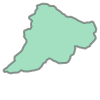

In [3]:
# ensure that the domain shape makes sense
domain_geometry = shape(domain['config'][0]['config'])
domain_geometry

In [4]:
# Search API request object
search_endpoint_request = {
  "item_types": [item_type],
  "filter": domain
}
result = \
  requests.post(
    'https://api.planet.com/data/v1/quick-search',
    auth=HTTPBasicAuth(apiKey, ''),
    json=search_endpoint_request)

In [5]:
# view available data and prepare the list of planet IDs to download
geojson_data = result.json()
gdf = gpd.GeoDataFrame.from_features(geojson_data['features'])

# Add a new column to 'gdf' with the intersection area
gdf['intersection_area'] = gdf['geometry'].intersection(domain_geometry).area

# Calculate the percentage overlap
gdf['overlap_percentage'] = (gdf['intersection_area'] / domain_geometry.area) * 100

gdf

,geometry,acquired,anomalous_pixels,cloud_cover,ground_control,gsd,instrument,item_type,pixel_resolution,provider,...,clear_percent,cloud_percent,heavy_haze_percent,light_haze_percent,shadow_percent,snow_ice_percent,visible_confidence_percent,visible_percent,intersection_area,overlap_percentage
0,"POLYGON ((-106.99039 39.09977, -107.04233 38.9...",2022-06-14T17:30:13.689573Z,0.0,0.00,True,4.0,PSB.SD,PSScene,3,planetscope,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002721,100.000000
1,"POLYGON ((-107.05043 39.09469, -107.10379 38.9...",2022-06-10T17:45:52.471842Z,0.0,0.00,True,4.0,PSB.SD,PSScene,3,planetscope,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002721,100.000000
2,"POLYGON ((-106.92524 39.01277, -106.9786 38.82...",2022-06-15T16:58:29.108433Z,0.0,0.00,True,4.0,PSB.SD,PSScene,3,planetscope,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000673,24.727090
3,"POLYGON ((-106.88359 39.15438, -106.93779 38.9...",2022-06-15T16:58:26.838274Z,0.0,0.00,True,4.0,PSB.SD,PSScene,3,planetscope,...,87.0,0.0,0.0,0.0,0.0,13.0,78.0,100.0,0.000636,23.385597
4,"POLYGON ((-106.98534 39.07702, -107.03736 38.8...",2022-06-18T17:31:29.975147Z,0.0,0.03,True,3.9,PSB.SD,PSScene,3,planetscope,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002721,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,"POLYGON ((-106.98562 38.95833, -107.03694 38.7...",2022-04-06T17:51:19.942667Z,0.0,0.00,True,3.9,PSB.SD,PSScene,3,planetscope,...,18.0,0.0,0.0,0.0,0.0,82.0,68.0,100.0,0.000022,0.791241
116,"POLYGON ((-106.9734 39.00786, -107.02375 38.82...",2022-03-27T17:48:01.524945Z,0.0,0.05,True,3.9,PSB.SD,PSScene,3,planetscope,...,6.0,5.0,0.0,0.0,0.0,89.0,58.0,95.0,0.002318,85.161908
117,"POLYGON ((-107.1477 39.00224, -107.1865 38.862...",2022-03-27T18:34:09.722144Z,0.0,0.00,True,3.6,PS2.SD,PSScene,3,planetscope,...,0.0,0.0,0.0,0.0,0.0,100.0,70.0,100.0,0.000470,17.267164
118,"POLYGON ((-107.12144 39.09694, -107.16049 38.9...",2022-03-27T18:34:08.222157Z,0.0,0.00,True,3.6,PS2.SD,PSScene,3,planetscope,...,0.0,0.0,0.0,0.0,0.0,99.0,67.0,100.0,0.002721,100.000000


In [6]:
# prep the ID and geometry lists
id_list = [feature['id'] for idx, feature in enumerate(geojson_data['features']) if gdf['overlap_percentage'].iloc[idx] >= 95]
geom_list = [feature['geometry'] for idx, feature in enumerate(geojson_data['features']) if gdf['overlap_percentage'].iloc[idx] >= 95]
print(len(id_list))
print(sorted(id_list))

43
['20220327_183408_22_1066', '20220406_175117_65_2405', '20220421_170043_03_241e', '20220421_173154_05_2461', '20220421_173301_48_24a5', '20220506_173005_62_2489', '20220509_171426_13_2276', '20220511_174519_13_241c', '20220512_173239_30_2477', '20220514_170001_22_2448', '20220515_173039_48_248e', '20220525_173032_77_2492', '20220526_165730_00_2451', '20220608_165851_16_2459', '20220608_173004_64_2498', '20220609_173032_58_249d', '20220610_173003_66_24a4', '20220610_174552_47_227b', '20220611_172932_33_2483', '20220613_173207_12_248b', '20220614_173013_68_2490', '20220616_165923_52_2439', '20220618_173129_97_2446', '20220621_173025_97_2490', '20220709_165814_93_242b', '20220717_173013_41_247d', '20220722_174435_02_240c', '20220818_165509_87_2459', '20220829_165707_66_2460', '20220829_173320_36_2492', '20220904_165651_73_2423', '20220905_172940_15_24a3', '20220907_174551_03_2426', '20220910_173331_48_2486', '20220911_165925_73_2434', '20220912_173406_34_2482', '20220913_165833_34_2435

In [ ]:
### ONLY RUN THIS CELL IF YOU WANT TO CHECK ON ORDER STATUS

# # see the status of the requested tiles. Are they "active"?
# for IDD in id_list:
#     print(IDD)
#     command = 'curl -L -H "Authorization: api-key '+apiKey+'"'
#     sublink = " 'https://api.planet.com/data/v1/item-types/"+item_type+"/items/"+IDD+"/assets/' "
#     # sublink = " 'https://api.planet.com/data/v2/item-types/"+item_type+"/items/"+IDD+"/assets/' "
#     command = command+sublink+'| jq .'+asset_type+'.status'
#     status = subprocess.run(command, shell=True)
#     print(command)
#     # break

In [7]:
# prepare and submit the orders
order_urls = pd.DataFrame(columns = ["index","ID_geom", "order_url"])

# loop through each order payload, and submit
for idx,IDD in enumerate(id_list):
    print(idx,IDD)
    
    payload = build_payload([IDD],item_type,bundle_type,domain['config'][0]['config']['coordinates'])
    order_url = order_now(payload,apiKey)
    
    order_urls.loc[idx, "index"] = idx        
    order_urls.loc[idx, "ID_geom"] = IDD
    order_urls.loc[idx, "order_url"] = order_url

0 20220614_173013_68_2490
<Response [202]>
Submitted a total of 1 image ids: accepted a total of 1 ids
Order URL: https://api.planet.com/compute/ops/orders/v2/2a937ed6-eac3-4b8c-aa05-cffeaea84353
1 20220610_174552_47_227b
<Response [202]>
Submitted a total of 1 image ids: accepted a total of 1 ids
Order URL: https://api.planet.com/compute/ops/orders/v2/4a0ac563-9e15-4b60-9ee5-80c84f33b76e
2 20220618_173129_97_2446
<Response [202]>
Submitted a total of 1 image ids: accepted a total of 1 ids
Order URL: https://api.planet.com/compute/ops/orders/v2/e2e4e220-6337-47fb-ab43-49efdedc18fa
3 20220621_173025_97_2490
<Response [202]>
Submitted a total of 1 image ids: accepted a total of 1 ids
Order URL: https://api.planet.com/compute/ops/orders/v2/c4b34a8c-3e54-4f51-9f48-30680cca6285
4 20220722_174435_02_240c
<Response [202]>
Submitted a total of 1 image ids: accepted a total of 1 ids
Order URL: https://api.planet.com/compute/ops/orders/v2/b831aa84-a9e8-4430-a6a3-625f9c03c447
5 20220525_173032_77

In [8]:
# check out the data, save to a csv if you want to come back later
print(order_urls)
order_urls.to_csv('COPP_urlSaver_2022.csv', index = None)# save all URLs

   index                  ID_geom  \
0      0  20220614_173013_68_2490   
1      1  20220610_174552_47_227b   
2      2  20220618_173129_97_2446   
3      3  20220621_173025_97_2490   
4      4  20220722_174435_02_240c   
5      5  20220525_173032_77_2492   
6      6  20220526_165730_00_2451   
7      7  20220406_175117_65_2405   
8      8  20220925_172721_32_222f   
9      9  20220924_175103_09_2413   
10    10  20220920_172939_56_247b   
11    11  20220919_165813_37_2453   
12    12  20220918_165701_10_241e   
13    13  20220913_173040_63_2495   
14    14  20220913_165833_34_2435   
15    15  20220912_173406_34_2482   
16    16  20220911_165925_73_2434   
17    17  20220910_173331_48_2486   
18    18  20220907_174551_03_2426   
19    19  20220905_172940_15_24a3   
20    20  20220904_165651_73_2423   
21    21  20220829_165707_66_2460   
22    22  20220829_173320_36_2492   
23    23  20220818_165509_87_2459   
24    24  20220717_173013_41_247d   
25    25  20220709_165814_93_242b   
2

In [ ]:
# Check this duplicates order I think
# create or add to URL saver csv
# url_saver = f'{name}_urlSaver.csv'

# if not os.path.exists(url_saver):
#     print(order_urls)
#     order_urls.to_csv(url_saver, index=None)  # Save all URLs
# else:
#     # If downloading dates separately, save the order_urls to already created csv when running for the first time
#     existing_urls = pd.read_csv(url_saver)
#     updated_urls = pd.concat([existing_urls, order_urls], ignore_index=True)
#     updated_urls.to_csv(url_saver, index=None)

In [2]:
order_urls = pd.read_csv('COPP_urlSaver_2022.csv')

In [5]:
# download the orders once ready
# outputs of "data not ready yet" mean that the orders need more time to process before downloading
for url in order_urls.itertuples():
    print(url.index,url.order_url)
    print("start downloading data to".format(), out_direc + url.ID_geom)
    if url.order_url != None:
        try:
            nantest = ~np.isnan(url.order_url)
        except:
            download_results(url.order_url,folder = out_direc + url.ID_geom)
    # break

0 https://api.planet.com/compute/ops/orders/v2/2a937ed6-eac3-4b8c-aa05-cffeaea84353
start downloading data to /data0/images/planet/emma/planet/COPP/20220614_173013_68_2490
5 items to download
/data0/images/planet/emma/planet/COPP/20220614_173013_68_2490/2a937ed6-eac3-4b8c-aa05-cffeaea84353/PSScene/20220614_173013_68_2490_metadata.json already exists, skipping 2a937ed6-eac3-4b8c-aa05-cffeaea84353/PSScene/20220614_173013_68_2490_metadata.json
/data0/images/planet/emma/planet/COPP/20220614_173013_68_2490/2a937ed6-eac3-4b8c-aa05-cffeaea84353/PSScene/20220614_173013_68_2490_3B_udm2_clip.tif already exists, skipping 2a937ed6-eac3-4b8c-aa05-cffeaea84353/PSScene/20220614_173013_68_2490_3B_udm2_clip.tif
/data0/images/planet/emma/planet/COPP/20220614_173013_68_2490/2a937ed6-eac3-4b8c-aa05-cffeaea84353/PSScene/20220614_173013_68_2490_3B_AnalyticMS_metadata_clip.xml already exists, skipping 2a937ed6-eac3-4b8c-aa05-cffeaea84353/PSScene/20220614_173013_68_2490_3B_AnalyticMS_metadata_clip.xml
/data0/

1 https://api.planet.com/compute/ops/orders/v2/4a0ac563-9e15-4b60-9ee5-80c84f33b76e
start downloading data to /data0/images/planet/emma/planet/COPP/20220610_174552_47_227b
5 items to download
downloading 4a0ac563-9e15-4b60-9ee5-80c84f33b76e/PSScene/20220610_174552_47_227b_metadata.json to /data0/images/planet/emma/planet/COPP/20220610_174552_47_227b/4a0ac563-9e15-4b60-9ee5-80c84f33b76e/PSScene/20220610_174552_47_227b_metadata.json
downloading 4a0ac563-9e15-4b60-9ee5-80c84f33b76e/PSScene/20220610_174552_47_227b_3B_udm2_clip.tif to /data0/images/planet/emma/planet/COPP/20220610_174552_47_227b/4a0ac563-9e15-4b60-9ee5-80c84f33b76e/PSScene/20220610_174552_47_227b_3B_udm2_clip.tif
downloading 4a0ac563-9e15-4b60-9ee5-80c84f33b76e/PSScene/20220610_174552_47_227b_3B_AnalyticMS_metadata_clip.xml to /data0/images/planet/emma/planet/COPP/20220610_174552_47_227b/4a0ac563-9e15-4b60-9ee5-80c84f33b76e/PSScene/20220610_174552_47_227b_3B_AnalyticMS_metadata_clip.xml
downloading 4a0ac563-9e15-4b60-9ee5-8